In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import qmc
from torch.optim import LBFGS
import time
import os
# Check if CUDA is available and set PyTorch device to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Puntos de muestreo

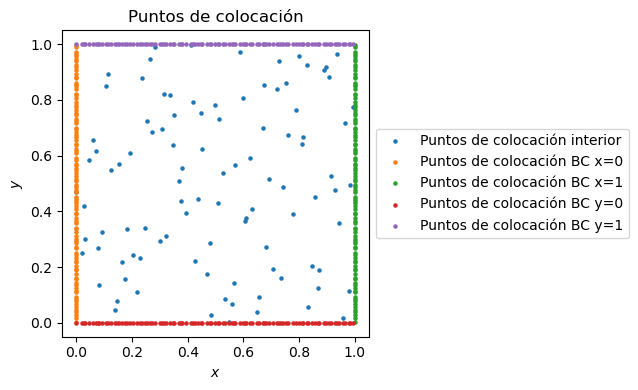

In [7]:
# Número de muestras en x y y
dom_samples = 100
x = np.linspace(0, 1, dom_samples)
y = np.linspace(0, 1, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

# Estrategia de muestreo LHS (Latin Hypercube Sampling)
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=dom_samples)

# límites inferior y superior del dominio
l_bounds = [ 0, 0]
u_bounds = [ 1, 1]
domain_xt = qmc.scale(sample, l_bounds, u_bounds)

# tensores de torch
x_ten = torch.tensor(domain_xt[:, 0], requires_grad = True).float().reshape(-1,1).to(device)
y_ten = torch.tensor(domain_xt[:, 1], requires_grad = True).float().reshape(-1,1).to(device)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(domain_xt[:, 0], domain_xt[:, 1], s=5,
           label='Puntos de colocación interior')
ax.scatter(np.zeros_like(y_ten.cpu().detach().numpy()), y_ten.cpu().detach().numpy(),
           s=5, label='Puntos de colocación BC x=0')
ax.scatter(np.ones_like(y_ten.cpu().detach().numpy()), y_ten.cpu().detach().numpy(),
           s=5, label='Puntos de colocación BC x=1')
ax.scatter(x_ten.cpu().detach().numpy(), np.zeros_like(x_ten.cpu().detach().numpy()),
           s=5, label='Puntos de colocación BC y=0')
ax.scatter(x_ten.cpu().detach().numpy(), np.ones_like(x_ten.cpu().detach().numpy()),
           s=5, label='Puntos de colocación BC y=1')   
ax.set_title('Puntos de colocación')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$') 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.axis("image")
plt.tight_layout()

In [14]:
domain = torch.cat([x_ten, y_ten], dim = 1)
domain.shape

torch.Size([100, 2])

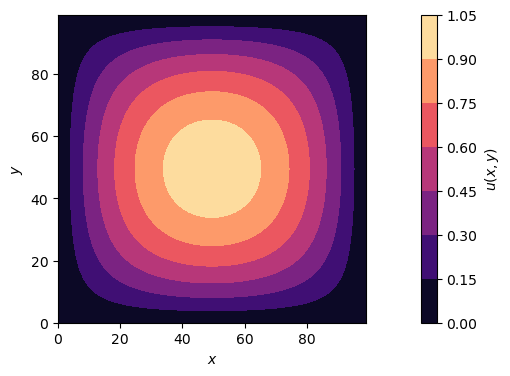

In [8]:
def u_analytic(x, y):
    return 16*(1 - x) * x * (1 - y) * y

# Mostrar la solución exacta u(x, y)
plt.figure(figsize=(6, 4))  
img = plt.contourf(u_analytic(X, Y), cmap='magma')
plt.colorbar(img, label='$u(x,y)$')   
plt.xlabel(r'$x$')   
plt.ylabel(r'$y$')
plt.axis("image")
plt.grid(False)

## Definición de Polinomios de Legendre

In [9]:
# Definición de la función de Legendre
def legendre(n, x):
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return x
    else:
        return ((2.0 * n - 1.0) * x * legendre(n - 1, x) - (n - 1) * legendre(n - 2, x)) / n
    
# Evaluación de la serie de Legendre 2-D utilizando broadcasting
def evaluate_legendre_series(x, y, coefficients, leg_x, leg_y):
    n = int(torch.sqrt(torch.tensor(coefficients.numel()).float()))  # Convert to tensor before sqrt
    coefficients = coefficients.view(n, n)
    
    # Utilizando broadcasting para calcular la serie de Legendre
    result = torch.sum(coefficients[:, :, None, None] * leg_x[:, None, :, :] * leg_y[None, :, :, :], dim=(0, 1))
    
    return result    

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Precomputar leg_x y leg_y una vez
start_precompute = time.time()

# Elige una suposición inicial para los coeficientes
N = 14  # Grado máximo de los polinomios de Legendre
initial_guess = torch.zeros(N*N, requires_grad=True, device=device)  # Suposición inicial para los coeficientes

# Datos de entrada para la función y los polinomios de Legendre
X1, X2 = torch.meshgrid(torch.linspace(-1, 1, 100, device=device), torch.linspace(-1, 1, 100, device=device))
 
n = int(torch.sqrt(torch.tensor(initial_guess.numel(), device=device).float()))
leg_x = torch.stack([legendre(i, X1).to(device) for i in range(n)], dim=0)
leg_y = torch.stack([legendre(j, X2).to(device) for j in range(n)], dim=0)
end_precompute = time.time()

# Medir el tiempo de precomputación
time_precompute = end_precompute - start_precompute
print(f"Tiempo de precomputación de Legendre polynomials: {time_precompute:.4f} segundos")